In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from natsort import natsorted
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
from nilearn.image import load_img
from nilearn.surface import vol_to_surf, load_surf_mesh
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import seaborn as sns
from nilearn import datasets, image
import matplotlib.cm as cm
from pygam import LinearGAM, s, f
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
from enigmatoolbox.permutation_testing import spin_test, shuf_test

In [2]:
regions = [
'SSp-n',
'VISp',
'Audp',
'SSp-m',
'SSp-bfd',
'SSp-ul',
'SSp-ll',
'SSs',
'TEa',
'ECT',
'PERI',
'AI',
'MOp',
'RSP',
'MOs',
'ACA',
'PL'] #'PTLp',

In [3]:
hurst = pd.read_csv('../../Derivatives/mouse/H_structural.csv')
age = pd.read_csv('../../Dataset/mouse/participants.tsv', sep = '\t')
atlas = pd.read_csv('../../Dataset/mouse/atlas.tsv', sep = '\t')

In [4]:
SSp_n = [x for x in atlas.name.values if 'Primary somatosensory area, nose' in x]
VISp = [x for x in atlas.name.values if 'Primary visual area' in x]
Audp =  [x for x in atlas.name.values if 'Primary auditory area' in x]
SSp_m = [x for x in atlas.name.values if 'Primary somatosensory area, mouth' in x]
SSp_bfd = [x for x in atlas.name.values if 'Primary somatosensory area, barrel field' in x]
SSp_ul = [x for x in atlas.name.values if 'Primary somatosensory area, upper limb' in x]
SSp_ll = [x for x in atlas.name.values if 'Primary somatosensory area, lower limb' in x]
SSs = [x for x in atlas.name.values if 'Supplemental somatosensory area' in x]
TEa = [x for x in atlas.name.values if 'Temporal association areas' in x]
ECT  = [x for x in atlas.name.values if 'Ectorhinal area' in x]
PERI = [x for x in atlas.name.values if 'Perirhinal area' in x]
AI = [x for x in atlas.name.values if 'Agranular insular area' in x]
MOp = [x for x in atlas.name.values if 'Primary motor area' in x]
RSP = [x for x in atlas.name.values if 'Retrosplenial area' in x]
#PTLp = [x for x in atlas.name.values if 'Posterior parietal association areas' in x]
MOs = [x for x in atlas.name.values if 'Secondary motor area' in x]
ACA = [x for x in atlas.name.values if 'Anterior cingulate area' in x]
PL = [x for x in atlas.name.values if 'Prelimbic area' in x]
#FRP = [x for x in atlas.name.values if 'Frontal pole, cerebral cortex' in x]

In [5]:
sa = []
for x in atlas['name'].values:
    if x in SSp_n:
        sa.append(0)
    elif x in VISp:
        sa.append(1)
    elif x in Audp:
        sa.append(2)
    elif x in SSp_m:
        sa.append(3)
    elif x in SSp_bfd:
        sa.append(4)
    elif x in SSp_ul:
        sa.append(5)
    elif x in SSp_ll:
        sa.append(6)
    elif x in SSs:
        sa.append(7)
    elif x in TEa:
        sa.append(8)
    elif x in ECT:
        sa.append(9)
    elif x in PERI:
        sa.append(10)
    elif x in AI:
        sa.append(11)
    elif x in MOp:
        sa.append(12)
    elif x in RSP:
        sa.append(13)
    #elif x in PTLp:
    #    sa.append(14)
    elif x in MOs:
        sa.append(14)
    elif x in ACA:
        sa.append(15)
    elif x in PL:
        sa.append(16)
    #elif x in FRP:
    #    sa.append(17)
    else:
        sa.append(-1)

In [6]:
H = hurst.T.iloc[:604, :]
H['sa'] = sa
hurst = pd.concat([H.iloc[:, :-1].T, age], axis=1)
H = H[H.sa>-1]

In [7]:
mmc3 = pd.read_csv('../../Dataset/mouse/celldensity_mmc3.csv', header=1)
mmc3 = mmc3[mmc3[' mean ']!=' N/D ']
mmc3 = mmc3[mmc3[' mean .2']!=' N/D ']
mmc3 = mmc3[mmc3[' mean .4']!=' N/D ']
mmc3 = mmc3[mmc3[' mean ']!=' - ']
mmc3 = mmc3[mmc3[' mean .2']!=' - ']
mmc3 = mmc3[mmc3[' mean .4']!=' - ']
mmc3 = mmc3[mmc3[' SD ']!=' N/D ']
mmc3 = mmc3[mmc3[' SD .2']!=' N/D ']
mmc3 = mmc3[mmc3[' SD .4']!=' N/D ']
mmc3 = mmc3[mmc3[' SD ']!=' - ']
mmc3 = mmc3[mmc3[' SD .2']!=' - ']
mmc3 = mmc3[mmc3[' SD .4']!=' - ']
mmc3['PVmean'] = [int(x.replace(',', '')) for x in mmc3[' mean ']]
mmc3['SSTmean'] = [int(x.replace(',', '')) for x in mmc3[' mean .2']]
mmc3['VIPmean'] = [int(x.replace(',', '')) for x in mmc3[' mean .4']]
mmc3['PVsd'] = [int(x.replace(',', '')) for x in mmc3[' SD ']]
mmc3['SSTsd'] = [int(x.replace(',', '')) for x in mmc3[' SD .2']]
mmc3['VIPsd'] = [int(x.replace(',', '')) for x in mmc3[' SD .4']]
regions = [
'SSp-n',
'VISp',
'AUDp',
'SSp-m',
'SSp-bfd',
'SSp-ul',
'SSp-ll',
'SSs',
'TEa',
'ECT',
'PERI',
'AI',
'MOp',
'RSP',
'MOs',
'ACA',
'PL'] #'PTLp',
areas = regions
df_t = pd.DataFrame()
for x in areas:
    df_t = pd.concat([df_t, mmc3[mmc3.ROI==x]])
    print([x,mmc3[mmc3.ROI==x].shape])
df_t = df_t.reset_index(drop=True)
my_palette = {c: sns.color_palette('Blues', n_colors=(4)).as_hex()[c+1] for c in np.arange(3)}
expression = df_t
expression['group'] = regions

['SSp-n', (1, 29)]
['VISp', (1, 29)]
['AUDp', (1, 29)]
['SSp-m', (1, 29)]
['SSp-bfd', (1, 29)]
['SSp-ul', (1, 29)]
['SSp-ll', (1, 29)]
['SSs', (1, 29)]
['TEa', (1, 29)]
['ECT', (1, 29)]
['PERI', (1, 29)]
['AI', (1, 29)]
['MOp', (1, 29)]
['RSP', (1, 29)]
['MOs', (1, 29)]
['ACA', (1, 29)]
['PL', (1, 29)]


In [8]:
hurst = pd.read_csv('../../Derivatives/mouse/H_structural.csv')
H = hurst.T.iloc[:604, :]
H['sa'] = sa
hurst = pd.concat([H.iloc[:, :-1].T, age], axis=1)
hurst = hurst[hurst.dataset=='AD1']

In [9]:
hurst_age = hurst.age.values
hurst_gender = hurst.gender.values
hurst = hurst.iloc[:, :604]
same = pd.DataFrame(hurst.std()<1e-10)

In [10]:
hurst = hurst.loc[:, [x for x in hurst.columns if x not in same[same[0]==True].index.values]]
hurst['age'] = hurst_age
hurst['gender'] = hurst_gender

In [11]:
hurst_selected = hurst.loc[:, H[H.sa>-1].index]
hurst_selected['age'] = hurst.age
hurst_selected['gender'] = hurst.gender

In [12]:
df_sa = pd.DataFrame(H[H.sa>-1].sa)
sa_bin = []
for x in df_sa.sa:
    if x < 6:
        sa_bin.append(1)
    elif x < 12:
        sa_bin.append(2)
    else:
        sa_bin.append(3)
df_sa['sa_bin'] = sa_bin

In [13]:
age_H = hurst_selected
sa = df_sa

In [14]:
sensory = age_H.iloc[:, [i for i in np.arange(34) if sa.sa[i]<8]+[-2]].groupby('age').mean().reset_index()
motor = age_H.iloc[:, [i for i in np.arange(34) if sa.sa[i] in [13,15]]+[-2]].groupby('age').mean().reset_index()
association =  age_H.iloc[:, [i for i in np.arange(34) if sa.sa[i] in [8,9,10,11,12,14,16,17]]+[-2]].groupby('age').mean().reset_index()

In [15]:
df = pd.DataFrame([age_H.iloc[:, [i for i in np.arange(34) if sa.sa[i] in [0,1,2,3,4,5,6,7,13,15]]].mean(axis=1).values, 
 age_H.iloc[:, [i for i in np.arange(34) if sa.sa[i] in [8,9,10,11,12,14,16,17]]].mean(axis=1).values]).T
df['age'] = age_H.age
df = df[df.age<9]

In [16]:
df_mean = df.groupby('age').mean().reset_index()
df_std = df.groupby('age').sem().reset_index()

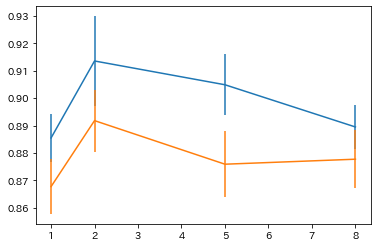

In [17]:
plt.errorbar(df_mean.age, df_mean[0], yerr=df_std[0])
plt.errorbar(df_mean.age, df_mean[1], yerr=df_std[1])
plt.savefig('mouse.eps')

In [18]:
[t,p] = stats.ttest_ind(df[df.age==1][0], df[df.age==2][0])
print(t,p)
[t,p] = stats.ttest_ind(df[df.age==1][1], df[df.age==2][1])
print(t,p)

-1.6126254267253046 0.1123495471539648
-1.5913987356877533 0.11705122396594116


In [19]:
for i in np.arange(2):
    print(stats.f_oneway(df[df.age==1][i], df[df.age==2][i],df[df.age==5][i], df[df.age==8][i]))
    print(df[df.age<=8].shape)
    print(stats.tukey_hsd(df[df.age==1][i], df[df.age==2][i], df[df.age==5][i], df[df.age==8][i]))

F_onewayResult(statistic=1.3993184042452078, pvalue=0.24706572929808518)
(111, 3)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.028     0.271    -0.068     0.012
 (0 - 2)     -0.019     0.593    -0.060     0.021
 (0 - 3)     -0.004     0.993    -0.043     0.035
 (1 - 0)      0.028     0.271    -0.012     0.068
 (1 - 2)      0.009     0.953    -0.035     0.052
 (1 - 3)      0.024     0.454    -0.018     0.067
 (2 - 0)      0.019     0.593    -0.021     0.060
 (2 - 1)     -0.009     0.953    -0.052     0.035
 (2 - 3)      0.015     0.780    -0.027     0.058
 (3 - 0)      0.004     0.993    -0.035     0.043
 (3 - 1)     -0.024     0.454    -0.067     0.018
 (3 - 2)     -0.015     0.780    -0.058     0.027

F_onewayResult(statistic=0.8490199120776274, pvalue=0.47008887546291)
(111, 3)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (